In [1]:
library(dplyr)
library(plyr)
library(tidyr)
library(data.table)
library(readxl)
library(stringr)
library(reshape2)
library(tidyverse)
library(broom)
library(rstatix)
library(autoReg)
library(rrtable)
library(skimr)
library(forestplot)

Warning message:
"package 'dplyr' was built under R version 4.3.2"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: 'plyr'


The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Warning message:
"package 'tidyr' was built under R version 4.3.3"
Warning message:
"package 'data.table' was built under R version 4.3.3"

Attaching package: 'data.table'


The following objects are masked from 'package

## 1. data summary

In [3]:
data=read.csv("../Data/1.labeled_train.csv",check.names = F)
df=data[,c(2,6:60)] %>% pivot_longer(cols = `年龄_month`:`前白蛋白_mg/L`, 
                     names_to = "features", 
                     values_to = "value")
summary(df)
df=na.omit(df)

   DiagSepsis       features             value        
 Min.   :0.0000   Length:40865       Min.   : -19.70  
 1st Qu.:0.0000   Class :character   1st Qu.:   2.41  
 Median :0.0000   Mode  :character   Median :  16.00  
 Mean   :0.4213                      Mean   :  51.64  
 3rd Qu.:1.0000                      3rd Qu.:  61.50  
 Max.   :1.0000                      Max.   :3545.00  
                                     NA's   :3362     

In [7]:
s.res = df %>% 
  group_by(features) %>% 
  nest() %>% 
  mutate(
    model = map(data, ~ shapiro.test(.$value)), 
    res = map(model, ~ tidy(.))
  ) %>% 
  unnest(res) 

s.res = s.res %>% 
  mutate(p.adjusted = p.adjust(p.value, method = "fdr"))%>% 
  mutate(normality = if_else(p.adjusted > 0.05, "Normal", "Non-normal"))
vars=s.res$features[which(s.res$normality=="Non-normal")]
#if consistent with normal distribution use t-test or not use Wilcox test
s.res$p.value

[1] 1.181235e-17 3.115954e-26 2.715082e-13 6.335879e-23 5.108245e-04
 [6] 3.937219e-06 3.862210e-07 7.516446e-39 1.364128e-24 4.507163e-07
[11] 2.054882e-04 1.854964e-09 1.238700e-21 1.470448e-11 3.190836e-10
[16] 4.890152e-28 3.890206e-12 5.861207e-03 6.716194e-20 1.955465e-14
[21] 3.447751e-27 2.229806e-21 3.870841e-19 4.732946e-19 2.368946e-14
[26] 6.791129e-11 3.079744e-32 1.244385e-15 1.799988e-23 2.516222e-26
[31] 4.989260e-35 1.117855e-19 3.286829e-06 6.558612e-42 5.244364e-42
[36] 1.318081e-24 1.393683e-20 3.501698e-24 1.930903e-41 2.103445e-34
[41] 9.904239e-47 3.155549e-45 3.946795e-03 6.287705e-45 2.395913e-14
[46] 1.457174e-12 1.574819e-44 1.373078e-44 7.047673e-25 8.373666e-06
[51] 6.692847e-20 1.289985e-47 5.745968e-39 1.063242e-28 7.190322e-08

In [8]:
#all use Wilcox test
data$DiagSepsis=as.factor(data$DiagSepsis)
data$gender=factor(data$性别,levels= c("男","女"),labels=c(1,0))
data[,6:60]=as.data.frame(lapply(data[,6:60],as.numeric))
sk.data=skim(data)
ft <- gaze(DiagSepsis~.,
           data=data[,c(2,6:61)],
           digits = 3,
           test = "wilcox") %>%myft()

## 2. single-factor logistics

In [9]:
Unilog<-function(x){
  FML<-as.formula(paste0("DiagSepsis~`",x,"`"))
  fm<-glm(FML,data,family = binomial()) #
  Sum<-summary(fm)
  orexp=exp(cbind('OR' = coef(fm), confint(fm,level = 0.95)))
  OR<-round(orexp[2,1],3)
  CI=paste0(round(orexp[2,2:3],3),collapse = "-") 
  lower=round(orexp[2,2],3)
  upper=round(orexp[2,3],3)
  Pval=Sum$coefficients[2,4] 
  Unilog<-data.frame("OR_with_CI"=paste(OR," (",lower,", ",upper,")"),
                     "Pvalue"=Pval,
                     "Odds Ratio"=OR,
                     "lower"=lower,
                     "upper"=upper)
  return(Unilog)
}

In [10]:
varNames<-colnames(data)[6:61] 
sk.data=skim(data)
del_n=sk.data$skim_variable[ which(sk.data$complete_rate<0.8)]
varNames=varNames[-which(varNames%in%del_n)]
length(varNames)
UniVar<-list()
for (nm in varNames){
  temp <- tryCatch(
    { Unilog(nm) },
    error = function(e) { message('Error @ ',nm) ; return(NA) },
    finally = { message('next...') 
    }
  )
  UniVar[[nm]] <- temp
}
UniVar<-ldply(UniVar,data.frame)
lg_Item<-UniVar$.id[UniVar$Pvalue <0.05]
lg_Item

[1] 55

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done...

next...

Waiting for profiling to be done..

[1] "年龄_month"                 "呼吸_次/分"                
 [3] "体温_℃"                     "体重_kg"                   
 [5] "心率_次/分"                 "氯_Cl-_mmol/L"             
 [7] "红细胞压积Hct_%"            "钠_Na+_mmol/L"             
 [9] "二氧化碳分压_pCO2_mmHg"     "酸碱度_pH_NULL"            
[11] "氧分压_pO2_mmHg"            "氧饱和度_sO2_%"            
[13] "钙（离子）Ca2+_mmol/L"      "中性粒细胞绝对值_×10^9/L"  
[15] "淋巴细胞绝对值_×10^9/L"     "平均血红蛋白浓度_g/L"      
[17] "血小板计数_×10^9/L"         "红细胞分布宽度_%"          
[19] "白细胞计数_×10^9/L"         "单核细胞绝对值_×10^9/L"    
[21] "嗜酸性粒细胞绝对值_×10^9/L" "白球比例_NULL"             
[23] "白蛋白_g/L"                 "丙氨酸氨基转移酶_U/L"      
[25] "天门冬氨酸氨基转移酶_U/L"   "钙_mmol/L"                 
[27] "胆固醇_mmol/L"              "肌酸激酶_U/L"              
[29] "肌酸激酶-MB活性_U/L"        "γ-谷氨酰基转移酶_U/L"      
[31] "球蛋白_g/L"                 "磷_mmol/L"                 
[33] "总胆汁酸_μmol/L"            "总胆红素_μmol/L"           
[35] "甘油三脂_mmol/L"            "总蛋白_g/L"                
[37] "尿酸_μmol/L"                "超敏C反应蛋白_mg/L"        
[39] "前白蛋白_mg/L"

In [11]:
uni_data=data[,c(1,2,which(colnames(data)%in%lg_Item))]

 DiagSepsis
 0:430     
 1:313     

Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '前白蛋白_mg/L' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '前白蛋白_mg/L' in 'mbcsToSbcs': dot substituted for <89>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '前白蛋白_mg/L' in 'mbcsToSbcs': dot substituted for <8d>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '前白蛋白_mg/L' in 'mbcsToSbcs': dot substituted for <e7>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '前白蛋白_mg/L' in 'mbcsToSbcs': dot substituted for <99>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '前白蛋白_mg/L' in 'mbcsToSbcs': dot substituted for <bd>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conver

Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '酸碱度_pH_NULL' in 'mbcsToSbcs': dot substituted for <e9>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '酸碱度_pH_NULL' in 'mbcsToSbcs': dot substituted for <85>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '酸碱度_pH_NULL' in 'mbcsToSbcs': dot substituted for <b8>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '酸碱度_pH_NULL' in 'mbcsToSbcs': dot substituted for <e7>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '酸碱度_pH_NULL' in 'mbcsToSbcs': dot substituted for <a2>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '酸碱度_pH_NULL' in 'mbcsToSbcs': dot substituted for <b1>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsi

Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <86>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <8e>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <8b>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '甘油三脂_mmol/L' in 'mbcsToSbcs': dot substituted for <e7>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '甘油三脂_mmol/L' in 'mbcsToSbcs': dot substituted for <94>"
Warning message in strwidth(t, units = "in", cex =

Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '淋巴细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <af>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '淋巴细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <b9>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '淋巴细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '淋巴细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <80>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '淋巴细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <bc>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '嗜酸性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in strwidth(t, units = "in",

Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '呼吸_次/分' in 'mbcsToSbcs': dot substituted for <bc>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '呼吸_次/分' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '呼吸_次/分' in 'mbcsToSbcs': dot substituted for <90>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '呼吸_次/分' in 'mbcsToSbcs': dot substituted for <b8>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '呼吸_次/分' in 'mbcsToSbcs': dot substituted for <e6>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '呼吸_次/分' in 'mbcsToSbcs': dot substituted for <ac>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '呼

Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '丙氨酸氨基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <a8>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '丙氨酸氨基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '丙氨酸氨基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <9f>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '丙氨酸氨基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <ba>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '丙氨酸氨基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <e8>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '丙氨酸氨基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <bd>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/

Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on 'γ-谷氨酰基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <b0>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on 'γ-谷氨酰基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on 'γ-谷氨酰基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <9f>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on 'γ-谷氨酰基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <ba>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on 'γ-谷氨酰基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <e8>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on 'γ-谷氨酰基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <bd>"
Warning message in strwidth(t, units = "in", cex = fontsiz

Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '肌酸激酶-MB活性_U/L' in 'mbcsToSbcs': dot substituted for <85>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '肌酸激酶-MB活性_U/L' in 'mbcsToSbcs': dot substituted for <b8>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '肌酸激酶-MB活性_U/L' in 'mbcsToSbcs': dot substituted for <e6>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '肌酸激酶-MB活性_U/L' in 'mbcsToSbcs': dot substituted for <bf>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '肌酸激酶-MB活性_U/L' in 'mbcsToSbcs': dot substituted for <80>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '肌酸激酶-MB活性_U/L' in 'mbcsToSbcs': dot substituted for <e9>"
Warning message in strwidth(t, units = "in", cex = fontsiz

Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '中性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <9d>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '中性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '中性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <af>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '中性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <b9>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '中性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '中性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <80>"
Warning message in strwidth(t, units = "

Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '尿酸_μmol/L' in 'mbcsToSbcs': dot substituted for <85>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '尿酸_μmol/L' in 'mbcsToSbcs': dot substituted for <b8>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '球蛋白_g/L' in 'mbcsToSbcs': dot substituted for <e7>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '球蛋白_g/L' in 'mbcsToSbcs': dot substituted for <90>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '球蛋白_g/L' in 'mbcsToSbcs': dot substituted for <83>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion failure on '球蛋白_g/L' in 'mbcsToSbcs': dot substituted for <e8>"
Warning message in strwidth(t, units = "in", cex = fontsize_row/fontsize):
"conversion fai

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <8c>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <96>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <e7>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <a2>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <b3>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <e5>

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <e6>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <b0>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <a7>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <8c>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '二氧化碳分压_pCO2_mmHg' in 'mbcsToSbcs': dot substituted for <96>

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '氧分压_pO2_mmHg' in 'mbcsToSbcs': dot substituted for <a7>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '氧分压_pO2_mmHg' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '氧分压_pO2_mmHg' in 'mbcsToSbcs': dot substituted for <88>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '氧分压_pO2_mmHg' in 'mbcsToSbcs': dot substituted for <86>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '氧分压_pO2_mmHg' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '氧分压_pO2_mmHg' in 'mbcsToSbcs': dot substituted for <8e>"
Warn

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '平均血红蛋白浓度_g/L' in 'mbcsToSbcs': dot substituted for <ba>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '平均血红蛋白浓度_g/L' in 'mbcsToSbcs': dot substituted for <a6>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '氯_Cl-_mmol/L' in 'mbcsToSbcs': dot substituted for <e6>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '氯_Cl-_mmol/L' in 'mbcsToSbcs': dot substituted for <b0>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '氯_Cl-_mmol/L' in 'mbcsToSbcs': dot substituted for <af>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '钠_Na+_mmol/L' in 'mbcsToSbcs': dot substituted for <e9>"
Warn

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '白球比例_NULL' in 'mbcsToSbcs': dot substituted for <bd>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '白球比例_NULL' in 'mbcsToSbcs': dot substituted for <e7>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '白球比例_NULL' in 'mbcsToSbcs': dot substituted for <90>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '白球比例_NULL' in 'mbcsToSbcs': dot substituted for <83>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '白球比例_NULL' in 'mbcsToSbcs': dot substituted for <e6>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '白球比例_NULL' in 'mbcsToSbcs': dot substituted for <af>"
Warning message in gri

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '嗜酸性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <e7>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '嗜酸性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '嗜酸性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <9d>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '嗜酸性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '嗜酸性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <af>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '嗜酸性粒细胞绝对值_×10^9/L' in 'mbcsToSbcs': 

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '心率_次/分' in 'mbcsToSbcs': dot substituted for <86>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '红细胞分布宽度_%' in 'mbcsToSbcs': dot substituted for <e7>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '红细胞分布宽度_%' in 'mbcsToSbcs': dot substituted for <ba>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '红细胞分布宽度_%' in 'mbcsToSbcs': dot substituted for <a2>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '红细胞分布宽度_%' in 'mbcsToSbcs': dot substituted for <e7>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '红细胞分布宽度_%' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.C

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '天门冬氨酸氨基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <97>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '天门冬氨酸氨基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <a8>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '天门冬氨酸氨基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '天门冬氨酸氨基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <86>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '天门冬氨酸氨基转移酶_U/L' in 'mbcsToSbcs': dot substituted for <ac>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '天门冬氨酸氨基转移酶_U/L' in 'mbcsToSbcs': dot substituted fo

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '总胆汁酸_μmol/L' in 'mbcsToSbcs': dot substituted for <e6>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '总胆汁酸_μmol/L' in 'mbcsToSbcs': dot substituted for <80>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '总胆汁酸_μmol/L' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '总胆汁酸_μmol/L' in 'mbcsToSbcs': dot substituted for <e8>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '总胆汁酸_μmol/L' in 'mbcsToSbcs': dot substituted for <83>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '总胆汁酸_μmol/L' in 'mbcsToSbcs': dot substituted for <86>"
Warning me

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '肌酸激酶-MB活性_U/L' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '肌酸激酶-MB活性_U/L' in 'mbcsToSbcs': dot substituted for <e6>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '肌酸激酶-MB活性_U/L' in 'mbcsToSbcs': dot substituted for <80>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '肌酸激酶-MB活性_U/L' in 'mbcsToSbcs': dot substituted for <a7>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '单核细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for <e5>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '单核细胞绝对值_×10^9/L' in 'mbcsToSbcs': dot substituted for 

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '白细胞计数_×10^9/L' in 'mbcsToSbcs': dot substituted for <e7>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '白细胞计数_×10^9/L' in 'mbcsToSbcs': dot substituted for <99>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '白细胞计数_×10^9/L' in 'mbcsToSbcs': dot substituted for <bd>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '白细胞计数_×10^9/L' in 'mbcsToSbcs': dot substituted for <e7>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '白细胞计数_×10^9/L' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '白细胞计数_×10^9/L' in 'mbcsToSbcs': dot substituted for <86>

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '球蛋白_g/L' in 'mbcsToSbcs': dot substituted for <83>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '球蛋白_g/L' in 'mbcsToSbcs': dot substituted for <e8>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '球蛋白_g/L' in 'mbcsToSbcs': dot substituted for <9b>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '球蛋白_g/L' in 'mbcsToSbcs': dot substituted for <8b>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '球蛋白_g/L' in 'mbcsToSbcs': dot substituted for <e7>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on '球蛋白_g/L' in 'mbcsToSbcs': dot substituted for <99>"
Warning message in grid.Call.graph

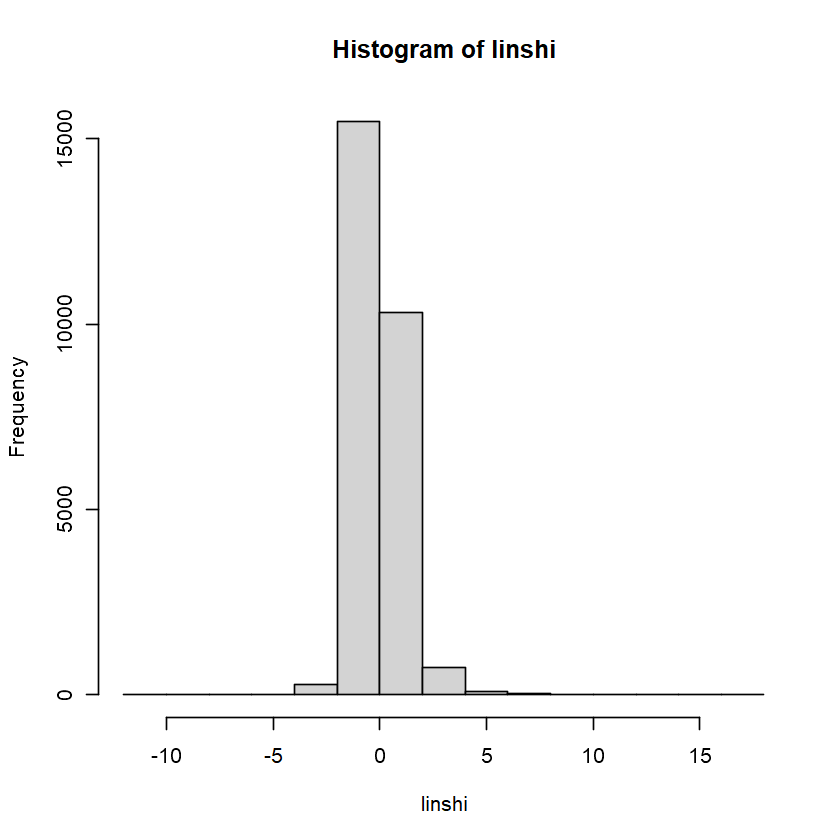

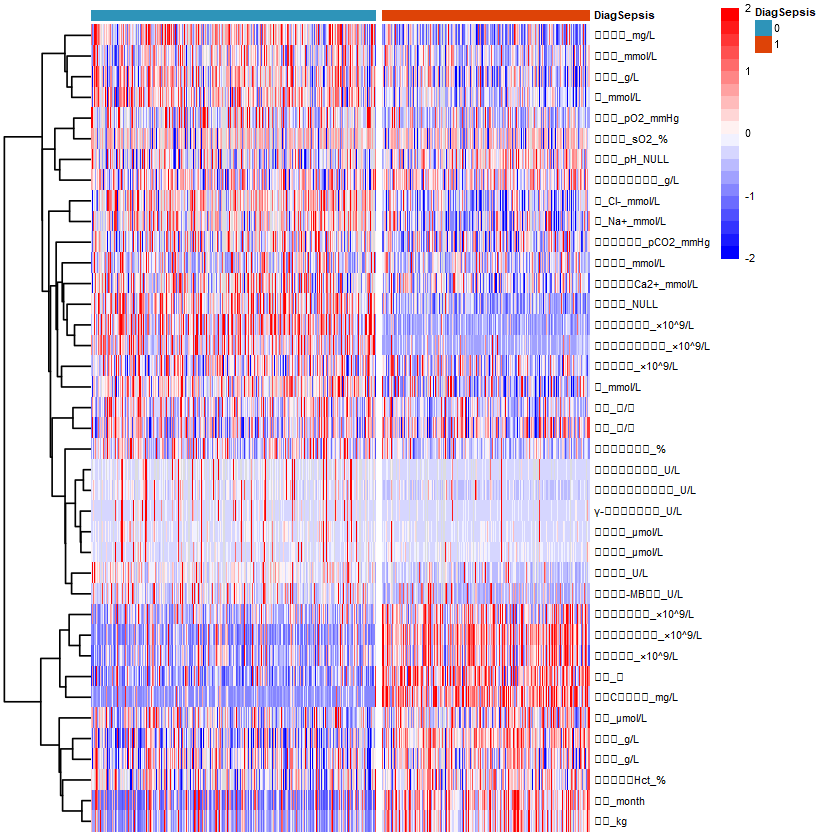

In [12]:
library(pheatmap)
udf=uni_data
udf<-udf[order(udf$DiagSepsis),]
heat_cli=udf[,2]#diag
heat_exp=udf[,3:41]
annotation_col = data.frame(DiagSepsis=as.factor(heat_cli))
summary(annotation_col)
rownames(annotation_col) <- udf$住院号
ann_colors = list(DiagSepsis=c("0"="#2E94B9","1"="#de4307"))
red <- rgb(255,0,0,maxColorValue = 255)
blue <- rgb(0,0,255,maxColorValue = 255)
white <- rgb(255,255,255,maxColorValue = 255)
linshi <- scale(heat_exp)
rownames(linshi) <- udf$住院号
linshi<-t(linshi)
hist(linshi)
linshi[linshi>2] <- 2
linshi[linshi<(-2)] <- c(-2)
pheatmap(linshi,fontsize=6,cutree_col = 4,gaps_col = 430,#cellheight = 2,cellwidth = 1 ,
         color  = colorRampPalette(c(blue,white,red))(20),
         annotation_col = annotation_col,
         annotation_colors = ann_colors,
         clustering_method = "ward.D2",
         border_color = "grey60",
         cluster_cols = F, cluster_rows = T,
         show_rownames = T, show_colnames = F
)

## 3. stepwise

In [14]:
mdata=udf[,-1]
slm=step(glm(DiagSepsis~., data =na.omit(mdata), family = binomial()))#
f.items=rownames(summary(slm)$coefficients)[which(round(summary(slm)$coefficients[,4],3)<0.05)]
f.items

Start:  AIC=443.93
DiagSepsis ~ 年龄_month + `呼吸_次/分` + `体温_℃` + 
    体重_kg + `心率_次/分` + `氯_Cl-_mmol/L` + `红细胞压积Hct_%` + 
    `钠_Na+_mmol/L` + 二氧化碳分压_pCO2_mmHg + 酸碱度_pH_NULL + 
    氧分压_pO2_mmHg + `氧饱和度_sO2_%` + `钙（离子）Ca2+_mmol/L` + 
    `中性粒细胞绝对值_×10^9/L` + `淋巴细胞绝对值_×10^9/L` + 
    `平均血红蛋白浓度_g/L` + `血小板计数_×10^9/L` + 
    `红细胞分布宽度_%` + `白细胞计数_×10^9/L` + 
    `单核细胞绝对值_×10^9/L` + `嗜酸性粒细胞绝对值_×10^9/L` + 
    白球比例_NULL + `白蛋白_g/L` + `丙氨酸氨基转移酶_U/L` + 
    `天门冬氨酸氨基转移酶_U/L` + `钙_mmol/L` + `胆固醇_mmol/L` + 
    `肌酸激酶_U/L` + `肌酸激酶-MB活性_U/L` + `γ-谷氨酰基转移酶_U/L` + 
    `球蛋白_g/L` + `磷_mmol/L` + `总胆汁酸_μmol/L` + 
    `总胆红素_μmol/L` + `甘油三脂_mmol/L` + `总蛋白_g/L` + 
    `尿酸_μmol/L` + `超敏C反应蛋白_mg/L` + `前白蛋白_mg/L`


Step:  AIC=443.93
DiagSepsis ~ 年龄_month + `呼吸_次/分` + `体温_℃` + 
    体重_kg + `心率_次/分` + `氯_Cl-_mmol/L` + `红细胞压积Hct_%` + 
    `钠_Na+_mmol/L` + 二氧化碳分压_pCO2_mmHg + 酸碱度_pH_NULL + 
    氧分压_pO2_mmHg + `氧饱和度_sO2_%` + `钙（离子）Ca2+_mmol/L` + 
    `中性粒细胞绝对值_×10^9/L` + `淋巴细胞绝对值_×10^9/L` + 
    `平均血红蛋白浓度_g/L` + `血小板计数

[1] "`心率_次/分`"               "`中性粒细胞绝对值_×10^9/L`"
[3] "`白细胞计数_×10^9/L`"       "白球比例_NULL"             
[5] "`天门冬氨酸氨基转移酶_U/L`" "`钙_mmol/L`"               
[7] "`γ-谷氨酰基转移酶_U/L`"     "`超敏C反应蛋白_mg/L`"      
[9] "`前白蛋白_mg/L`"

In [15]:
formatFit<-function(fit){
  p_val<-summary(fit)$coefficients[,4]
  wald<-summary(fit)$coefficients[,3]^2
  valueB<-summary(fit)$coefficients[,1]
  valueOR<-exp(valueB)
  lower=exp(valueB-1.96*summary(fit)$coefficients[,2]) 
  upper=exp(valueB+1.96*summary(fit)$coefficients[,2])
  data.frame(
    OR_with_CI=paste(round(valueOR,3),"(",
                     round(lower,3),"-",round(upper,3),")",sep=""),
    P=round(p_val,3),
    coef=round(valueB,3),
    Wald=round(wald,3),
    exp.coef=round(valueOR,3),
    lower=round(lower,3),
    upper=round(upper,3)
  )
}
data_f=formatFit(slm)

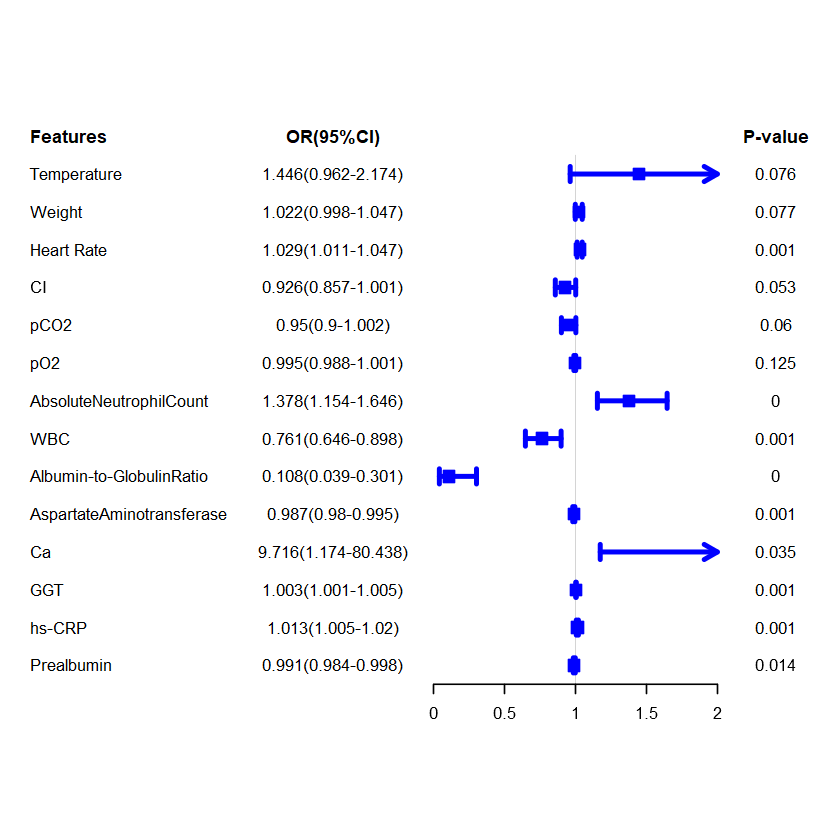

In [16]:
fdata=read.csv("../Data/forestplot_labeltoEN.csv",check.names = F)
forestplot(as.matrix(fdata[,c(1:3)]),fdata$exp.coef,fdata$lower,
           fdata$upper,zero = 1,xlog = F,
           clip = c(0,2),
           colgap = unit(5,"mm"),graphwidth=unit(60,"mm"),
           lineheight = unit(0.8,"cm"),graph.pos = 3,
           col = fpColors(box="blue", lines="blue", zero = "grey"),boxsize = 0.3,
           ci.vertices = T,ci.vertices.height = 0.2,
           lty.ci = 7,lwd.zero=0.4,lwd.ci = 3,
           txt_gp=fpTxtGp(label = gpar(cex=0.8),
                          ticks = gpar(cex=0.8)) ,
           is.summary=c(TRUE,rep(FALSE,100)))